In [1]:
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt
import seaborn as sns
from Models import probitModel, logisticModel
from util import *
from sklearn.preprocessing import *
from sklearn.impute import *
from sklearn.decomposition import PCA

import json
import joblib

In [2]:
SEED = 1

data_folder = 'data'
df = pd.read_csv(os.path.join(data_folder,'mimiciv_traindata.csv'))
df.head()

,Fraction inspired oxygen_mean,Fraction inspired oxygen_min,Fraction inspired oxygen_max,Glucose_mean,Glucose_min,Glucose_max,Heart Rate_mean,Heart Rate_min,Heart Rate_max,Mean blood pressure_mean,...,Temperature_mean,Temperature_min,Temperature_max,Weight_mean,Weight_min,Weight_max,pH_mean,pH_min,pH_max,mortality
0,0.484615,0.4,0.6,155.181818,52.0,280.0,52.367347,35.0,93.0,87.096154,...,36.356349,35.200000,37.100000,81.419764,81.419764,81.419764,7.328750,7.19,7.40,1.0
1,0.600000,0.5,1.0,127.954545,85.0,177.0,72.660377,58.0,105.0,72.315789,...,36.786325,36.388889,37.055556,93.103510,91.807021,95.000000,7.377143,7.34,7.42,0.0
2,0.481250,0.4,0.8,145.625000,116.0,180.0,107.260000,96.0,118.0,86.462963,...,37.316239,36.611111,37.944444,67.500000,67.500000,67.500000,7.372000,7.29,7.45,0.0
3,0.400000,0.4,0.4,100.142857,77.0,154.0,57.250000,47.0,65.0,69.762712,...,NaN,NaN,NaN,80.403091,76.838485,86.000000,7.161250,6.00,7.36,1.0
4,0.566667,0.4,1.0,138.000000,116.0,155.0,84.015625,64.0,114.0,70.662162,...,36.148990,34.722222,37.666667,NaN,NaN,NaN,7.374444,7.27,7.42,1.0


In [3]:
x = compute_features(df.drop('mortality',axis=1))
y = df.mortality.values

In [4]:
# base pipeline is the common step for both models
base_pipeline = [
    ('scaler', QuantileTransformer(output_distribution='normal', ignore_implicit_zeros=False)),
]

with open('../others/probit.json','r') as f:
    probit_param = json.load(f)
with open('../others/logistic.json','r') as f:
    logistic_param = json.load(f)

print(probit_param)
print(logistic_param)
    

{'l1': 0.006171888786369539, 'l2': 0.0405715442762844, 'n_neighbors': 11.767930181820343}
{'l1': 0.0027408409818461266, 'l2': 0.00904159656998016, 'n_neighbors': 14.699223795046494}


# Probit Model

In [5]:
probit_pipeline = base_pipeline + [
        ('iso_forest', FeatureTransformer(fnames=x.columns, n_neighbors=int(probit_param['n_neighbors']))),
        ('imputer', KNNImputer(missing_values=np.nan, n_neighbors=int(probit_param['n_neighbors']))),
]

probit_pipeline = Pipeline(probit_pipeline)
probit_x = probit_pipeline.fit_transform(x)
probit = probitModel(l1=probit_param['l1'], l2=probit_param['l2'], w=0.75)

# smaller tol for improved accuracy
res_dict = probit.fit(probit_x, y, verbose=True, wald=True)
result = res_dict['result']
loss_values = res_dict['loss']

Loss improved, update best parameters.
Current loss: 0.8831531042409062 Best loss: 0.8831531042409062
Loss improved, update best parameters.
Current loss: 0.694033011224544 Best loss: 0.694033011224544
Loss improved, update best parameters.
Current loss: 0.568256878499415 Best loss: 0.568256878499415
Loss improved, update best parameters.
Current loss: 0.5017217639214614 Best loss: 0.5017217639214614
Loss improved, update best parameters.
Current loss: 0.49605496545475164 Best loss: 0.49605496545475164
Loss improved, update best parameters.
Current loss: 0.4956029987635716 Best loss: 0.4956029987635716
Loss improved, update best parameters.
Current loss: 0.49476324782842795 Best loss: 0.49476324782842795
Loss improved, update best parameters.
Current loss: 0.4946521815427499 Best loss: 0.4946521815427499
Optimization result: Optimization terminated successfully
Wald test summary:
+----+---------+--------------+-----------+---------+---------+
|    |   index |         coef |   std err |

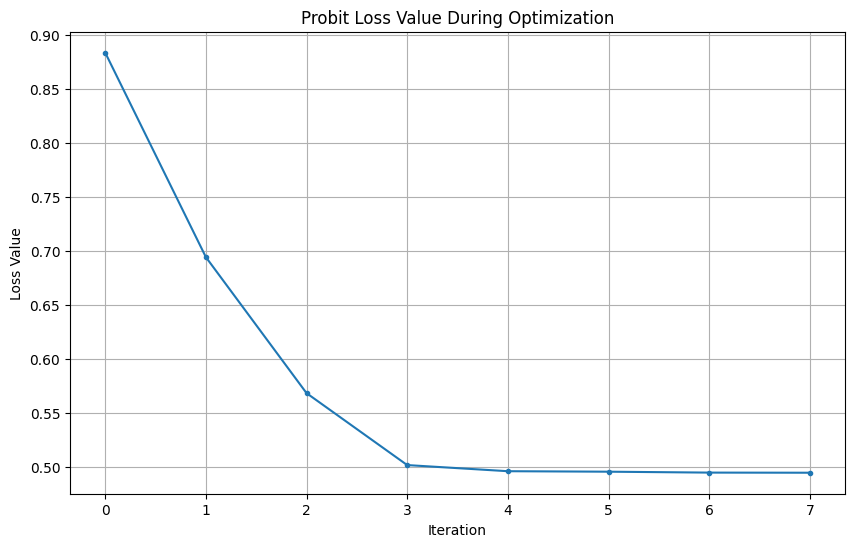

In [6]:
plt.figure(figsize=(10, 6))
plt.plot(loss_values, marker='.', linestyle='-')
plt.title('Probit Loss Value During Optimization')
plt.xlabel('Iteration')
plt.ylabel('Loss Value')
plt.grid()
plt.show()

## Wald test result and model interpretation

In [7]:
# iso_forest in pipeline will add a feature 'is_outlier', and last parameter in the model is the bias term
fnames = x.columns.to_list()+['is_outlier']+['bias']
# map the indices back to feature names
index_to_feature = dict(zip(range(len(fnames)),fnames))
wald_res = res_dict['wald_result']
wald_res['index'] = wald_res['index'].replace(index_to_feature, inplace=False)
wald_res.rename(columns={'index':'feature'}, inplace=True)
# show top 5 important features, wald test result is sorted by p-value in acsending order
wald_res.head(5)


,feature,coef,std err,z,P>|z|
0,Oxygen saturation_min,-0.048209,0.0329,-1.4637,0.1433
1,Respiratory rate_mean,0.095568,0.0862,1.1089,0.2675
2,Temperature_min,-0.056358,0.0521,-1.0824,0.2791
3,is_outlier,-0.057193,0.0577,-0.9913,0.3215
4,Temperature_mean,-0.068612,0.0791,-0.8672,0.3858


### Interpretation
Positive coef -> higher feature value, higher mortality risk

Negative coef -> higher feature value, lower mortality risk
- Higher Oxygen saturation_min decrease mortality risk (or lower increase risk)
- Higher Respiratory rate_mean increases mortality risk
- Higher Temperature_min decrease mortality risk (or lower increase risk)
- Inliniers (1 for inliner, -1 for outlier) lower mortality risk (outliers higher risk)
- Higher Temperature_mean decrease mortality risk (or lower increase risk)



## Saving the model

In [8]:
joblib.dump(probit_pipeline, '../others/probit_pipeline.pkl')
joblib.dump(probit, '../others/probit.pkl')

['../others/probit.pkl']

# Logistic Model

In [9]:
logistic_pipeline = base_pipeline + [ #
        ('iso_forest', FeatureTransformer(fnames=x.columns, n_neighbors=int(logistic_param['n_neighbors']))),
        ('imputer', KNNImputer(missing_values=np.nan, n_neighbors=int(logistic_param['n_neighbors']))),
]

logistic_pipeline = Pipeline(logistic_pipeline)
logistic_x = logistic_pipeline.fit_transform(x)
logistic = logisticModel(l1=logistic_param['l1'], l2=logistic_param['l2'], w=0.75)

res_dict = logistic.fit(logistic_x, y, verbose=True, wald=True)
result = res_dict['result']
loss_values = res_dict['loss']


Loss improved, update best parameters.
Current loss: 0.5195174335708473 Best loss: 0.5195174335708473
Loss improved, update best parameters.
Current loss: 0.5151596548781837 Best loss: 0.5151596548781837
Loss improved, update best parameters.
Current loss: 0.4945718343928413 Best loss: 0.4945718343928413
Loss improved, update best parameters.
Current loss: 0.4879144868242139 Best loss: 0.4879144868242139
Loss improved, update best parameters.
Current loss: 0.4869145947288032 Best loss: 0.4869145947288032
Loss improved, update best parameters.
Current loss: 0.48618940229851404 Best loss: 0.48618940229851404
Loss improved, update best parameters.
Current loss: 0.485800597889529 Best loss: 0.485800597889529
Loss improved, update best parameters.
Current loss: 0.48557389340745805 Best loss: 0.48557389340745805
Loss improved, update best parameters.
Current loss: 0.48540545505541266 Best loss: 0.48540545505541266
Loss improved, update best parameters.
Current loss: 0.4852820338523064 Best l

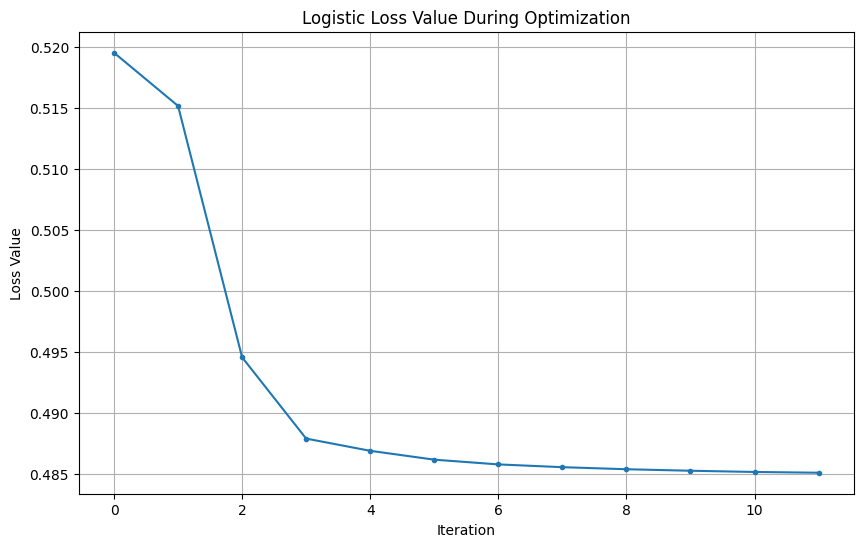

In [10]:
plt.figure(figsize=(10, 6))
plt.plot(loss_values, marker='.', linestyle='-')
plt.title('Logistic Loss Value During Optimization')
plt.xlabel('Iteration')
plt.ylabel('Loss Value')
plt.grid()
plt.show()

## Wald test result and model interpretation

In [11]:
# iso_forest in pipeline will add a feature 'is_outlier', and last parameter in the model is the bias term
fnames = x.columns.to_list()+['is_outlier']+['bias']
# map the indices back to feature names
index_to_feature = dict(zip(range(len(fnames)),fnames))
wald_res = res_dict['wald_result']
wald_res['index'] = wald_res['index'].replace(index_to_feature, inplace=False)
wald_res.rename(columns={'index':'feature'}, inplace=True)
# show top 5 important features, wald test result is sorted by p-value in acsending order
wald_res.head(5)


,feature,coef,std err,z,P>|z|
0,Oxygen saturation_min,-0.105109,0.0551,-1.9064,0.0566
1,is_outlier,-0.151197,0.0978,-1.5462,0.1221
2,Respiratory rate_mean,0.182200,0.1419,1.2836,0.1993
3,Temperature_mean,-0.145546,0.1300,-1.1199,0.2627
4,Temperature_min,-0.093339,0.0847,-1.1015,0.2707


### Interpretation
Positive coef -> higher feature value, higher mortality risk

Negative coef -> higher feature value, lower mortality risk
- Higher Oxygen saturation_min decrease mortality risk (or lower increase risk)
- Inliniers (1 for inliner, -1 for outlier) lower mortality risk (outliers higher risk)
- Higher Respiratory rate_mean increases mortality risk
- Higher Temperature_mean decrease mortality risk (or lower increase risk)
- Higher Temperature_min decrease mortality risk (or lower increase risk)

Consistent with Probit model but with slightly different order of p-values
(It is expected, since both are linear models with the same set of features, just different assumed error distributions)


## Saving the model

In [12]:
joblib.dump(logistic_pipeline, '../others/logistic_pipeline.pkl')
joblib.dump(logistic, '../others/logistic.pkl')

['../others/logistic.pkl']

# Model evaluation

We evaluate our models using 5-fold cross validation with best hyperparameters 

### Probit model
For the sake of clarity, we load the data, hyperparameters and models again

In [13]:
# load the data
df = pd.read_csv(os.path.join(data_folder,'mimiciv_traindata.csv'))
x = compute_features(df.drop('mortality',axis=1))
y = df.mortality.values

In [14]:
# load the best hyperparameters
with open('../others/probit.json','r') as f:
    probit_param = json.load(f)
print(probit_param)

{'l1': 0.006171888786369539, 'l2': 0.0405715442762844, 'n_neighbors': 11.767930181820343}


In [15]:
# base pipeline is the common step for both models
base_pipeline = [
    ('scaler', QuantileTransformer(output_distribution='normal', ignore_implicit_zeros=False)),
]

In [16]:
# pipeline for probit model

probit_pipeline = base_pipeline + [
    ('iso_forest', FeatureTransformer(fnames=x.columns, n_neighbors=int(probit_param['n_neighbors']))),
    ('imputer', KNNImputer(missing_values=np.nan, n_neighbors=int(probit_param['n_neighbors']))),
    ('model',probitModel(l1=probit_param['l1'], l2=probit_param['l2'], w=0.75)),
]

In [17]:
# Perform 5-fold cross validation
# The evaluation result will be saved in the 'probit' folder
_ = cv(probit_pipeline, x.values, y, 5, random_state=SEED, verbose=True, path='../others/probit')

Fold 1 evaluation result:
Accuracy: 0.66283
Precision: 0.39706
Recall: 0.66784
F1 Score: 0.49802
AUC score: 0.72400
Optimal threshold is 0.49495, at F1 score of 0.50584

Fold 2 evaluation result:
Accuracy: 0.65221
Precision: 0.38298
Recall: 0.63604
F1 Score: 0.47809
AUC score: 0.67756
Optimal threshold is 0.50505, at F1 score of 0.48043

Fold 3 evaluation result:
Accuracy: 0.64570
Precision: 0.38037
Recall: 0.65724
F1 Score: 0.48187
AUC score: 0.69389
Optimal threshold is 0.49495, at F1 score of 0.48669

Fold 4 evaluation result:
Accuracy: 0.62445
Precision: 0.35815
Recall: 0.62898
F1 Score: 0.45641
AUC score: 0.66054
Optimal threshold is 0.53535, at F1 score of 0.45640

Fold 5 evaluation result:
Accuracy: 0.63330
Precision: 0.37030
Recall: 0.66078
F1 Score: 0.47462
AUC score: 0.68702
Optimal threshold is 0.52525, at F1 score of 0.49014

Mean F1 score: 0.47780, std: 0.01337
Mean AUC score: 0.68860, std: 0.02094
Mean Precision score: 0.37777, std: 0.01301
Mean Recall score: 0.65018, std

### Logistic model
We do the same thing for the logistic model

In [18]:
with open('../others/logistic.json','r') as f:
    logistic_param = json.load(f)
print(logistic_param)

{'l1': 0.0027408409818461266, 'l2': 0.00904159656998016, 'n_neighbors': 14.699223795046494}


In [19]:
logistic_pipeline = base_pipeline + [
    ('iso_forest', FeatureTransformer(fnames=x.columns, n_neighbors=int(logistic_param['n_neighbors']))),
    ('imputer', KNNImputer(missing_values=np.nan, n_neighbors=int(logistic_param['n_neighbors']))),
    ('model',probitModel(l1=logistic_param['l1'], l2=logistic_param['l2'], w=0.75)),
]

In [20]:
_ = cv(logistic_pipeline, x.values, y, 5, random_state=SEED, verbose=True, path='../others/logistic')

Fold 1 evaluation result:
Accuracy: 0.66726
Precision: 0.39644
Recall: 0.62898
F1 Score: 0.48634
AUC score: 0.72072
Optimal threshold is 0.53535, at F1 score of 0.49371

Fold 2 evaluation result:
Accuracy: 0.66460
Precision: 0.39041
Recall: 0.60424
F1 Score: 0.47434
AUC score: 0.68270
Optimal threshold is 0.52525, at F1 score of 0.48706

Fold 3 evaluation result:
Accuracy: 0.65899
Precision: 0.38865
Recall: 0.62898
F1 Score: 0.48043
AUC score: 0.68755
Optimal threshold is 0.49495, at F1 score of 0.48549

Fold 4 evaluation result:
Accuracy: 0.62622
Precision: 0.35551
Recall: 0.60424
F1 Score: 0.44764
AUC score: 0.66619
Optimal threshold is 0.48485, at F1 score of 0.45658

Fold 5 evaluation result:
Accuracy: 0.65810
Precision: 0.39248
Recall: 0.66431
F1 Score: 0.49344
AUC score: 0.69870
Optimal threshold is 0.50505, at F1 score of 0.49531

Mean F1 score: 0.47644, std: 0.01573
Mean AUC score: 0.69117, std: 0.01810
Mean Precision score: 0.38470, std: 0.01482
Mean Recall score: 0.62615, std